# Tidy data

In this notebook, we take a closer look at the [British Library books dataset](https://github.com/mromanello/ADA-DHOxSS/tree/master/data) and tidy it up.

In [4]:
# imports

import pandas as pd
import json, os, codecs, requests
from collections import defaultdict, OrderedDict
import seaborn as sns

## Import the dataset
Let us import the sample dataset in memory, as it is, without transformations. We rely on some Python libraries to do so.

In [7]:
# book metadata
m_url = "https://raw.githubusercontent.com/mromanello/ADA-DHOxSS/master/data/bl_books/sample/book_data_sample.json"
r = requests.get(m_url)
metadata = r.json()

In [23]:
# load the fulltexts (we need to do some gymnastics to load from GitHub)
user = "mromanello"
repo = "ADA-DHOxSS"
raw_root = "https://raw.githubusercontent.com/mromanello/ADA-DHOxSS/master/"
data_root = "data/bl_books/sample/full_texts/"

url = "https://api.github.com/repos/{}/{}/git/trees/master?recursive=1".format(user, repo)
r = requests.get(url)
res = r.json()

texts = defaultdict(list)
for file in res["tree"]:
    file = file["path"]
    if ".json" in file and file.startswith(data_root):
        r = requests.get(raw_root+file)
        t = r.json()
        texts[file.split("/")[-1]] = t

In [24]:
# enriched metadata
em_url = "https://raw.githubusercontent.com/mromanello/ADA-DHOxSS/master/data/bl_books/sample/extra_metadata_sample.csv"
df_extra = pd.read_csv(em_url, delimiter=";")
df_extra = df_extra.rename(str.lower, axis='columns') # rename columns to lower case

## Take a look
Let's take a look to the dataset

In [25]:
# there are 452 books in the sample

print(len(metadata))

452


In [26]:
# each one contains the following catalog metadata

metadata[0]

{'datefield': '1841',
 'shelfmarks': ['British Library HMNTS 11601.ddd.2.'],
 'publisher': 'Privately printed',
 'title': ["The Poetical Aviary, with a bird's-eye view of the English poets. [The preface signed: A. A.] Ms. notes"],
 'edition': '',
 'flickr_url_to_book_images': 'http://www.flickr.com/photos/britishlibrary/tags/sysnum000000196',
 'place': 'Calcutta',
 'issuance': 'monographic',
 'authors': {'creator': ['A. A.']},
 'date': '1841',
 'pdf': {'1': 'lsidyv35c55757'},
 'identifier': '000000196',
 'corporate': {},
 'fulltext_filename': 'sample/full_texts/000000196_01_text.json'}

**Questions** on 'metadata':

* Can you identify some messy aspects of this dataset representation?
* Take a look at the 'shelfmarks' or 'title' fields: what is the problem here?
* Do the same for the 'authors' and 'pdf' fields: what is the problem?
* Look at the datefield of the *third* item in this list: is there a problem?

In [27]:
# let's check we have the same amount of books with a text file

print(len(texts))

452


*Note: we have selected for the sample just the first volume/pdf for every book.*

In [28]:
# each text comes as a list of lists: one per page, as follows [page number, text]

texts['000000196_01_text.json'][:9]

[[1, ''],
 [2, ''],
 [3, ''],
 [4, ''],
 [5, ''],
 [6, ''],
 [7,
  "THE POETICAL AVIARY, WITH A B I R D'S-E YE VIEW OF THE ENGLISH POETS. (NOT PUBLISHED.) CALCUTTA: PRINTED AT THE BAPTIST MISSION PRESS, CIRCULAR ROAD. 1841."],
 [8, ''],
 [9,
  'POETICAL AVIARY. PART THE FIRST. BIRDS WITHOUT ALLUSION TO THEIR NOTES. One of the curious political medals that were struck in the reign of Charles II. represents, on one side, Titus Oates with two faces. On the reverse are the heads of the king and four of his principal ministers, with this motto round the border, " Birds of a feather flock together." This, as well as various other proverbs derived from birds, haee been introduced into poetry. Thus Anstey — And \'twas pretty to see how like birds of a feather The people of quality flocked all together, All pressing, addressing, caressing, and fond, Just the same as those animals do in a pond. Under the sign of an inn representing a man with a bird in his hand, and two birds in a bush I have se

In [29]:
# the extra metadata can be already used as a data frame

df_extra[df_extra["first_pdf"] == "lsidyv35c55757"]
# we perform here a selection of rows which abide to a given condition. We'll see more of this later on.

,aleph system no.,country code,language code (008),language code (041),ddc,personal author,corporate author,title,edition,imprint,series,subjects,other personal authors,other corporate authors,dom id,type,genre,first_pdf
234,14846757,|||,eng,NaN,NaN,A. A.,NaN,"The Poetical Aviary, with a bird's-eye view of...",NaN,"Calcutta : Privately printed, 1841.",NaN,NaN,NaN,NaN,lsidyv35c55757,poet,Poetry,lsidyv35c55757


**Question**: explore this data frame and find examples of messy aspects.

In [30]:
# Create data frames for all datasets
# We drop some variables we don't need at this stage

# metadata
datefield = list() # '1841'
publisher = list() # 'Privately printed',
title = list() # ["The Poetical Aviary, with a bird's-eye view of the English poets. [The preface signed: A. A.] Ms. notes"]
edition = list() # ''
place = list() # 'Calcutta'
issuance = list() # 'monographic'
authors = list() # {'creator': ['A. A.']}
first_pdf = list() # {'1': 'lsidyv35c55757'}
number_volumes = list()
identifier = list() # '000000196'
fulltext_filename = list() # 'sample/full_texts/000000196_01_text.json'
for book in metadata:
    if book["date"]:
        datefield.append(int(book["date"][:4]))
    else:
        datefield.append(None)
    publisher.append(book["publisher"])
    title.append(book["title"][0])
    edition.append(book["edition"])
    place.append(book["place"])
    issuance.append(book["issuance"])
    if "creator" in book["authors"].keys():
        authors.append(book["authors"]["creator"]) # this is a list!
    else:
        authors.append([''])
    first_pdf.append(book["pdf"]["1"])
    number_volumes.append(len(book["pdf"]))
    identifier.append(book["identifier"])
    fulltext_filename.append(book["fulltext_filename"].split("/")[-1])
df_meta = pd.DataFrame.from_dict({"datefield": datefield, "publisher": publisher,
                                 "title": title, "edition": edition, "place": place,
                                 "issuance": issuance, "authors": authors, "first_pdf": first_pdf,
                                 "number_volumes": number_volumes, "identifier": identifier,
                                 "fulltext_filename": fulltext_filename})

# texts
how_many_pages = 50 # we reduce the amount of text to the first n pages, to make it faster to play with it
fulltext_filename = list()
fulltext = list()
for f,t in texts.items():
    fulltext_filename.append(f)
    text = " ".join([line[1] for line in t][:how_many_pages])
    fulltext.append(text)

df_texts = pd.DataFrame.from_dict({"fulltext_filename": fulltext_filename, "fulltext": fulltext})

In [31]:
df_meta.head(5)

,datefield,publisher,title,edition,place,issuance,authors,first_pdf,number_volumes,identifier,fulltext_filename
0,1841.0,Privately printed,"The Poetical Aviary, with a bird's-eye view of...",,Calcutta,monographic,[A. A.],lsidyv35c55757,1,000000196,000000196_01_text.json
1,1888.0,Rivingtons,A History of Greece. Part I. From the earliest...,,London,monographic,"[Abbott, Evelyn]",lsidyv376da437,1,000004047,000004047_01_text.json
2,1847.0,Punch Office,The Comic History of England ... With ... colo...,,London,monographic,"[A'BECKETT, Gilbert Abbott.]",lsidyv38b27a31,1,000005382,000005382_01_text.json
3,1892.0,"Eden, Remington & Co.",The Cruise of “The Tomahawk”: the story of a s...,,London,monographic,"[Laffan, De Courcy - Mrs]",lsidyv3c4a946a,1,000014627,000014627_01_text.json
4,1863.0,Virtue Bros. & Co.,Scenes from the Drama of European History,,London,monographic,"[Adams, W. H. Davenport (William Henry Davenpo...",lsidyv32c34c22,1,000017057,000017057_01_text.json


In [32]:
df_texts.head(1)

,fulltext_filename,fulltext
0,000000196_01_text.json,"THE POETICAL AVIARY, WITH A B I R D'S-E ..."


## A second look
Let's check data types and typical values to be sure of what we have.

In [33]:
df_meta.dtypes

datefield            float64
publisher             object
title                 object
edition               object
place                 object
issuance              object
authors               object
first_pdf             object
number_volumes         int64
identifier            object
fulltext_filename     object
dtype: object

<AxesSubplot:>

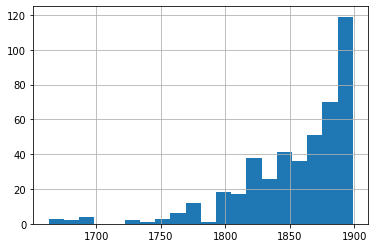

In [34]:
df_meta["datefield"].hist(bins=20)

<AxesSubplot:>

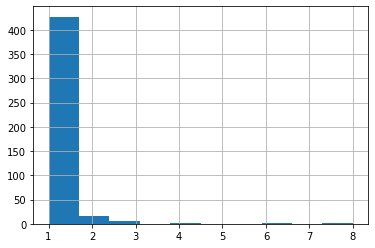

In [35]:
df_meta["number_volumes"].hist()

In [36]:
variable = "place"
df_meta[variable].value_counts()[:11]

London          243
New York         23
Dublin           10
Philadelphia     10
Edinburgh         9
enk               8
Leeds             8
Boston            6
Cambridge         6
                  5
Oxford            5
Name: place, dtype: int64

In [37]:
df_meta[variable].value_counts()[-10:]

St. Andrews                   1
Brighton                      1
New Haven                     1
Selkirk                       1
Littleborough                 1
Angusta [Mo.]                 1
Springfield, Mass             1
Worthing, London [printed]    1
Leamington                    1
Newcastle                     1
Name: place, dtype: int64

In [38]:
df_extra["genre"].value_counts()

Music     120
Poetry    120
Drama     120
Prose     120
Name: genre, dtype: int64

In [39]:
df_extra["type"].value_counts()

story         106
opera          79
play           64
ode            53
poet           37
song           36
tragedy        32
comedy         18
verse          10
lines           9
recitation      6
romance         6
elegy           6
tale            3
melody          3
novel           3
lyric           2
hymn            2
satire          2
rhyme           2
ballad          1
Name: type, dtype: int64

**Questions**:
    
* 'place' seems like a reasonably uniform variable. Try with 'edition' instead, and think about how that might be more problematic.
* While the 'genre' variable is uniform in representation, the 'type' variable is not. Can you find out what are the most well-represented types for each genre category? How might this influence our use of 'type' for analysis?

## Tidying up

Here is the model we want to end-up with, organised in tables and relations among them:

* Full view (for your curiosity): https://dbdiagram.io/d/5d06a4adfff7633dfc8e3a42
* Reduced view (we here use this one): https://dbdiagram.io/d/5d06a5d0fff7633dfc8e3a47

In [40]:
# first, join the extra metadata genre column to the metadata data frame. More details on joins in class 3.1.

df_extra_genre = df_extra[["type","genre","first_pdf"]]
df_book = df_meta.join(df_extra_genre.set_index('first_pdf'), on='first_pdf')

In [41]:
df_book.head(1)

,datefield,publisher,title,edition,place,issuance,authors,first_pdf,number_volumes,identifier,fulltext_filename,type,genre
0,1841.0,Privately printed,"The Poetical Aviary, with a bird's-eye view of...",,Calcutta,monographic,[A. A.],lsidyv35c55757,1,000000196,000000196_01_text.json,poet,Poetry


In [42]:
# second, add the book_id to the book_text dataframe

df_book_text = df_texts.join(df_book[["identifier","fulltext_filename"]].set_index('fulltext_filename'), on='fulltext_filename')
df_book_text = df_book_text.rename(columns={"identifier":"book_id"})
df_book_text.head(3)

,fulltext_filename,fulltext,book_id
0,000000196_01_text.json,"THE POETICAL AVIARY, WITH A B I R D'S-E ...",000000196
1,000004047_01_text.json,HISTORY OF GREECE ABBOTT A HISTORY OF G...,000004047
2,000005382_01_text.json,COMH HIST0R1 OF ENGLAND. THE BY GILBERT...,000005382


In [43]:
# third, pull our author information and create the author table and the author-book table

author_id = 0 # this is a counter which provides for a distinct identifier to every author
author_dict = OrderedDict()
author_book_table = {"book_id":list(),"author_id":list()}
for book_id, authors in df_book[["identifier","authors"]].values:
    for author in authors:
        if author not in author_dict.keys():
            author_dict[author] = author_id
            author_id += 1
        author_book_table["book_id"].append(book_id)
        author_book_table["author_id"].append(author_dict[author])
        
df_author_book = pd.DataFrame.from_dict(author_book_table)
df_author = pd.DataFrame.from_dict({"name":[v for v in author_dict.keys()],
                                   "id":[k for k in author_dict.values()]})
df_author.set_index("id", inplace=True)

In [44]:
df_author.head(3)

,name
id,
0,A. A.
1,"Abbott, Evelyn"
2,"A'BECKETT, Gilbert Abbott."


In [45]:
df_author_book.head(3)

,book_id,author_id
0,000000196,0
1,000004047,1
2,000005382,2


In [46]:
# drop authors from df_books

df_book.drop(columns=["authors"], inplace=True)

*And we are done!*

## A last look at the tidy dataset

**Questions**:
* how many authors are there? Are there books with more than one author? And authors who published more than one book?
* How many books per genre do we have?
* What is the typical year of publication of our books?

---